In [16]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_sp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_128/enc_test_128.npy')
stim_pred = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_128/pred_test_128.npy')
stim_y = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_128/y_test_128.npy')
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_128/resp_test_128.npy')

In [4]:
stim_err = stim_y - stim_pred
stim_spec = np.concatenate((stim_sp, stim_err), axis=1)

In [17]:
np.shape(stim_sp), np.shape(stim_err)

((5706, 128), (5706, 32))

In [5]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 160), (5706, 214, 32))

In [6]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [7]:
nsegbins = 32

In [8]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [9]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 160), (5706, 214))

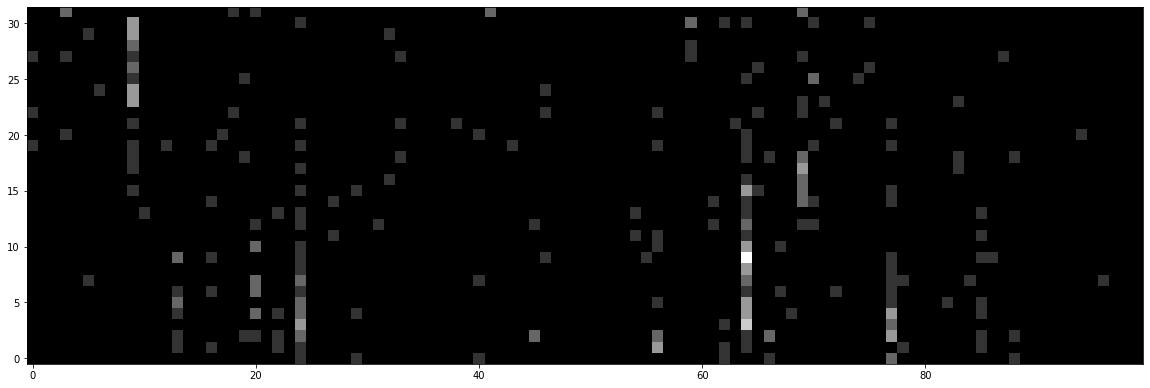

In [10]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [11]:
len_units = np.shape(resp_mne)[1]

In [12]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy'))

In [13]:
exp_path = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_128/error_mne/'

In [14]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 128
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.167823
    2       0    0.165398
    3       0    0.163500
    4       0    0.162050
    5       0    0.158130
    6       0    0.159642
    7       1    0.160384
    8       2    0.160563
    9       3    0.162539
   10       4    0.162668
   11       5    0.161921
   12       6    0.160795
   13       7    0.161537
   14       8    0.162227
   15       9    0.161214
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.155969
    2       0    0.153955
    3       0    0.155226
    4       1    0.151754
    5       0    0.154916
    6       1    0.154532
    7       2    0.152786
    8       3    0.151117
    9       0    0.150516
   10       0    0.152363
   11       1    0.150242
   12       0    0.149680
   13       0    0.150601
   14       1    0.149428
   15       0    0.150005
   16       1    0.149993
   17       2    0.150494
   18       3    0.151629
   19       4    0.151484
   20       5    0.151907
   21       

   12       1    0.091597
   13       2    0.092350
   14       3    0.092126
   15       4    0.091878
   16       5    0.092194
   17       6    0.093131
   18       7    0.093635
   19       8    0.092918
   20       9    0.093008
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.101942
    2       0    0.100355
    3       0    0.100967
    4       1    0.100320
    5       0    0.098497
    6       0    0.098522
    7       1    0.098475
    8       0    0.098639
    9       1    0.099946
   10       2    0.099529
   11       3    0.100092
   12       4    0.099605
   13       5    0.099667
   14       6    0.099527
   15       7    0.099720
   16       8    0.099690
   17       9    0.099217
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.094173
    2       0    0.092579
    3       0    0.092411
    4       0    0.091886
    5       0    0.091014
    6       0    0.090748
    7       0    0.090225
    8       0    0.090087
    9       

   15       3    0.112028
   16       4    0.111955
   17       5    0.110947
   18       0    0.112636
   19       1    0.113613
   20       2    0.112181
   21       3    0.111956
   22       4    0.111511
   23       5    0.111779
   24       6    0.112761
   25       7    0.112092
   26       8    0.112333
   27       9    0.112615
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.123128
    2       0    0.122342
    3       0    0.120518
    4       0    0.118781
    5       0    0.117139
    6       0    0.116497
    7       0    0.115673
    8       0    0.115490
    9       0    0.115371
   10       0    0.115186
   11       0    0.114986
   12       0    0.115446
   13       1    0.115366
   14       2    0.114557
   15       0    0.114867
   16       1    0.115209
   17       2    0.115604
   18       3    0.115231
   19       4    0.115137
   20       5    0.115134
   21       6    0.115349
   22       7    0.115416
   23       8    0.116872
   24       

    1       0    0.299588
    2       0    0.293454
    3       0    0.290788
    4       0    0.290617
    5       0    0.289488
    6       0    0.285950
    7       0    0.283816
    8       0    0.284031
    9       1    0.283749
   10       0    0.284021
   11       1    0.283537
   12       0    0.284290
   13       1    0.282470
   14       0    0.282946
   15       1    0.282044
   16       0    0.282730
   17       1    0.282392
   18       2    0.282473
   19       3    0.283239
   20       4    0.282624
   21       5    0.282831
   22       6    0.282274
   23       7    0.282502
   24       8    0.281974
   25       0    0.281778
   26       0    0.282683
   27       1    0.282703
   28       2    0.283080
   29       3    0.283245
   30       4    0.282683
   31       5    0.282704
   32       6    0.282860
   33       7    0.283527
   34       8    0.284255
   35       9    0.285683
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.294053
    2       

   19       4    0.164599
   20       5    0.164621
   21       6    0.164742
   22       7    0.165518
   23       8    0.165930
   24       9    0.166263
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.166431
    2       0    0.165420
    3       0    0.164330
    4       0    0.163070
    5       0    0.162725
    6       0    0.162823
    7       1    0.162322
    8       0    0.161467
    9       0    0.161387
   10       0    0.161217
   11       0    0.161119
   12       0    0.161310
   13       1    0.161023
   14       0    0.160620
   15       0    0.160578
   16       0    0.160760
   17       1    0.160932
   18       2    0.160691
   19       3    0.160825
   20       4    0.160752
   21       5    0.160875
   22       6    0.160706
   23       7    0.160497
   24       0    0.160495
   25       0    0.160495
   26       0    0.160716
   27       1    0.160650
   28       2    0.160667
   29       3    0.160659
   30       4    0.160755
   31       

    4       1    0.134277
    5       2    0.131738
    6       0    0.132236
    7       1    0.131726
    8       0    0.131088
    9       0    0.131890
   10       1    0.133640
   11       2    0.132864
   12       3    0.132344
   13       4    0.131555
   14       5    0.132037
   15       6    0.132247
   16       7    0.132885
   17       8    0.132521
   18       9    0.132857
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.305676
    2       0    0.302215
    3       0    0.299093
    4       0    0.298277
    5       0    0.300075
    6       1    0.301737
    7       2    0.296185
    8       0    0.294646
    9       0    0.294711
   10       1    0.295478
   11       2    0.294247
   12       0    0.293363
   13       0    0.293588
   14       1    0.294077
   15       2    0.295144
   16       3    0.294324
   17       4    0.293539
   18       5    0.294079
   19       6    0.294587
   20       7    0.293673
   21       8    0.293878
   22       

   13       1    0.239194
   14       2    0.237693
   15       0    0.237754
   16       1    0.237298
   17       0    0.237513
   18       1    0.238211
   19       2    0.237302
   20       3    0.238692
   21       4    0.239190
   22       5    0.238241
   23       6    0.238208
   24       7    0.238025
   25       8    0.238209
   26       9    0.238065
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.135162
    2       0    0.133644
    3       0    0.132222
    4       0    0.132973
    5       1    0.132037
    6       0    0.133756
    7       1    0.135136
    8       2    0.133414
    9       3    0.133909
   10       4    0.134018
   11       5    0.133622
   12       6    0.132726
   13       7    0.132919
   14       8    0.132522
   15       9    0.131631
   16       0    0.131607
   17       0    0.131763
   18       1    0.131722
   19       2    0.132372
   20       3    0.133873
   21       4    0.134662
   22       5    0.134082
   23       

    3       0    0.589210
    4       0    0.586180
    5       0    0.583976
    6       0    0.582213
    7       0    0.581866
    8       0    0.581699
    9       0    0.580134
   10       0    0.579587
   11       0    0.579604
   12       1    0.579834
   13       2    0.580186
   14       3    0.580486
   15       4    0.581551
   16       5    0.581568
   17       6    0.581546
   18       7    0.581720
   19       8    0.582434
   20       9    0.583619
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.587434
    2       0    0.585728
    3       0    0.578220
    4       0    0.574514
    5       0    0.574164
    6       0    0.571215
    7       0    0.571423
    8       1    0.570519
    9       0    0.570060
   10       0    0.568938
   11       0    0.567811
   12       0    0.567809
   13       0    0.568437
   14       1    0.569336
   15       2    0.570623
   16       3    0.569071
   17       4    0.568072
   18       5    0.568076
   19       

Iters   tally   ll(test) 
    1       0    0.047130
    2       0    0.047691
    3       0    0.048484
    4       1    0.047802
    5       2    0.048058
    6       3    0.047083
    7       0    0.046725
    8       0    0.046677
    9       0    0.046564
   10       0    0.046889
   11       1    0.046683
   12       2    0.047000
   13       3    0.047264
   14       4    0.047014
   15       5    0.046742
   16       6    0.046665
   17       7    0.046729
   18       8    0.047095
   19       9    0.046933
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.054151
    2       0    0.057224
    3       0    0.057244
    4       1    0.057394
    5       2    0.055518
    6       0    0.055286
    7       0    0.053776
    8       0    0.053452
    9       0    0.054883
   10       1    0.054508
   11       2    0.054786
   12       3    0.055552
   13       4    0.054477
   14       5    0.053710
   15       6    0.054419
   16       7    0.054542
   17       

    5       0    0.069838
    6       1    0.070315
    7       2    0.069025
    8       0    0.068685
    9       0    0.070420
   10       1    0.069905
   11       2    0.070835
   12       3    0.070664
   13       4    0.070535
   14       5    0.070375
   15       6    0.069903
   16       7    0.070017
   17       8    0.069922
   18       9    0.070125
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.077382
    2       0    0.077481
    3       0    0.075491
    4       0    0.072503
    5       0    0.069808
    6       0    0.069608
    7       0    0.069243
    8       0    0.068796
    9       0    0.069263
   10       1    0.069243
   11       2    0.069256
   12       3    0.068958
   13       4    0.068725
   14       0    0.068631
   15       0    0.068325
   16       0    0.068411
   17       1    0.069345
   18       2    0.069107
   19       3    0.069453
   20       4    0.069726
   21       5    0.069557
   22       6    0.070243
   23       

    3       0    0.228342
    4       0    0.226184
    5       0    0.222795
    6       0    0.221488
    7       0    0.220478
    8       0    0.220893
    9       1    0.219869
   10       0    0.221338
   11       1    0.220537
   12       2    0.220016
   13       3    0.220364
   14       4    0.219711
   15       0    0.220078
   16       1    0.220518
   17       2    0.220163
   18       3    0.220518
   19       4    0.220811
   20       5    0.219560
   21       0    0.219930
   22       1    0.220460
   23       2    0.219817
   24       3    0.220020
   25       4    0.221819
   26       5    0.222491
   27       6    0.224884
   28       7    0.225752
   29       8    0.226559
   30       9    0.227799
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.251190
    2       0    0.243650
    3       0    0.240456
    4       0    0.237300
    5       0    0.233141
    6       0    0.230878
    7       0    0.230405
    8       0    0.231621
    9       

Iters   tally   ll(test) 
    1       0    0.149416
    2       0    0.156074
    3       0    0.155556
    4       0    0.148901
    5       0    0.145613
    6       0    0.145071
    7       0    0.144297
    8       0    0.145883
    9       1    0.144911
   10       2    0.145050
   11       3    0.144758
   12       4    0.144688
   13       5    0.145394
   14       6    0.144689
   15       7    0.145973
   16       8    0.146527
   17       9    0.147633
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.662155
    2       0    0.661582
    3       0    0.659475
    4       0    0.658334
    5       0    0.657666
    6       0    0.657755
    7       1    0.658396
    8       2    0.657716
    9       3    0.657599
   10       0    0.657568
   11       0    0.658150
   12       1    0.658970
   13       2    0.657540
   14       0    0.657185
   15       0    0.657194
   16       1    0.657268
   17       2    0.657371
   18       3    0.657301
   19       

   17       3    0.592603
   18       4    0.592436
   19       5    0.591888
   20       6    0.592432
   21       7    0.592607
   22       8    0.591884
   23       9    0.593231
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.192862
    2       0    0.185362
    3       0    0.182514
    4       0    0.183060
    5       1    0.178802
    6       0    0.177581
    7       0    0.180291
    8       1    0.180469
    9       2    0.180287
   10       3    0.179993
   11       4    0.179440
   12       5    0.179729
   13       6    0.179905
   14       7    0.177017
   15       0    0.176507
   16       0    0.176725
   17       1    0.176865
   18       2    0.177055
   19       3    0.178535
   20       4    0.177658
   21       5    0.176604
   22       6    0.176741
   23       7    0.177018
   24       8    0.177231
   25       9    0.177631
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.214202
    2       0    0.209947
    3       

    8       0    0.146486
    9       1    0.144501
   10       2    0.142803
   11       0    0.143762
   12       1    0.143902
   13       2    0.143822
   14       3    0.148185
   15       4    0.147906
   16       5    0.145680
   17       6    0.146134
   18       7    0.145212
   19       8    0.146909
   20       9    0.146868
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.161622
    2       0    0.158583
    3       0    0.161061
    4       1    0.159315
    5       2    0.153899
    6       0    0.153481
    7       0    0.154961
    8       1    0.155473
    9       2    0.157099
   10       3    0.153910
   11       4    0.155914
   12       5    0.155447
   13       6    0.155344
   14       7    0.153188
   15       0    0.154169
   16       1    0.155468
   17       2    0.154831
   18       3    0.154219
   19       4    0.154579
   20       5    0.153552
   21       6    0.154075
   22       7    0.155792
   23       8    0.155848
   24       

   18       4    0.435802
   19       5    0.435750
   20       6    0.436095
   21       7    0.436163
   22       8    0.435965
   23       9    0.436359
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.642726
    2       0    0.640040
    3       0    0.639674
    4       0    0.639162
    5       0    0.639803
    6       1    0.640528
    7       2    0.639981
    8       3    0.639433
    9       4    0.637728
   10       0    0.637181
   11       0    0.636470
   12       0    0.636285
   13       0    0.636642
   14       1    0.637628
   15       2    0.637397
   16       3    0.636951
   17       4    0.640088
   18       5    0.641576
   19       6    0.639710
   20       7    0.639949
   21       8    0.640342
   22       9    0.640686
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.638566
    2       0    0.634277
    3       0    0.634061
    4       0    0.632554
    5       0    0.630520
    6       0    0.631567
    7       

    9       0    0.388996
   10       0    0.388969
   11       0    0.388834
   12       0    0.391262
   13       1    0.391215
   14       2    0.390389
   15       3    0.390220
   16       4    0.391292
   17       5    0.391234
   18       6    0.390591
   19       7    0.390774
   20       8    0.390763
   21       9    0.391308
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.413452
    2       0    0.406878
    3       0    0.403169
    4       0    0.403544
    5       1    0.402703
    6       0    0.400858
    7       0    0.402933
    8       1    0.403546
    9       2    0.400099
   10       0    0.399454
   11       0    0.400474
   12       1    0.399881
   13       2    0.398518
   14       0    0.399272
   15       1    0.399732
   16       2    0.401401
   17       3    0.401758
   18       4    0.401136
   19       5    0.401636
   20       6    0.402212
   21       7    0.402751
   22       8    0.402446
   23       9    0.403368
minimum of t

   12       5    0.182647
   13       6    0.183132
   14       7    0.182673
   15       8    0.181751
   16       9    0.181787
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.196367
    2       0    0.193819
    3       0    0.188835
    4       0    0.186646
    5       0    0.185285
    6       0    0.184979
    7       0    0.183726
    8       0    0.183774
    9       1    0.183859
   10       2    0.183953
   11       3    0.185509
   12       4    0.185552
   13       5    0.185094
   14       6    0.184618
   15       7    0.184416
   16       8    0.184760
   17       9    0.184612
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.491115
    2       0    0.488358
    3       0    0.484013
    4       0    0.482558
    5       0    0.480401
    6       0    0.477840
    7       0    0.477146
    8       0    0.475228
    9       0    0.473738
   10       0    0.474059
   11       1    0.474030
   12       2    0.473562
   13       

   15       0    0.353393
   16       1    0.353454
   17       2    0.353358
   18       3    0.353880
   19       4    0.354073
   20       5    0.356057
   21       6    0.358651
   22       7    0.359262
   23       8    0.360440
   24       9    0.360344
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.354078
    2       0    0.353364
    3       0    0.352071
    4       0    0.352636
    5       1    0.350219
    6       0    0.348141
    7       0    0.347719
    8       0    0.347452
    9       0    0.348365
   10       1    0.351010
   11       2    0.351419
   12       3    0.352323
   13       4    0.351074
   14       5    0.351406
   15       6    0.351321
   16       7    0.351447
   17       8    0.351239
   18       9    0.351175
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.357417
    2       0    0.356156
    3       0    0.353119
    4       0    0.351087
    5       0    0.349815
    6       0    0.350795
    7       

   19       6    0.436919
   20       7    0.437300
   21       8    0.437246
   22       9    0.437316
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.447474
    2       0    0.444005
    3       0    0.441609
    4       0    0.441729
    5       1    0.441406
    6       0    0.441938
    7       1    0.441249
    8       0    0.440002
    9       0    0.439954
   10       0    0.439749
   11       0    0.439675
   12       0    0.439940
   13       1    0.439489
   14       0    0.438727
   15       0    0.440050
   16       1    0.440920
   17       2    0.442328
   18       3    0.445047
   19       4    0.447481
   20       5    0.446325
   21       6    0.446041
   22       7    0.445630
   23       8    0.445490
   24       9    0.445495
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.232443
    2       0    0.231949
    3       0    0.236888
    4       1    0.235619
    5       2    0.230754
    6       0    0.229978
    7       

    1       0    0.490193
    2       0    0.485046
    3       0    0.481091
    4       0    0.479530
    5       0    0.477260
    6       0    0.476824
    7       0    0.477714
    8       1    0.477999
    9       2    0.475522
   10       0    0.474502
   11       0    0.473831
   12       0    0.475126
   13       1    0.476143
   14       2    0.476494
   15       3    0.476412
   16       4    0.476594
   17       5    0.477302
   18       6    0.478138
   19       7    0.478662
   20       8    0.477746
   21       9    0.477178
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.094212
    2       0    0.092826
    3       0    0.092136
    4       0    0.089797
    5       0    0.088223
    6       0    0.089146
    7       1    0.088538
    8       2    0.087631
    9       0    0.088247
   10       1    0.087838
   11       2    0.088316
   12       3    0.089260
   13       4    0.088459
   14       5    0.089013
   15       6    0.089850
   16       

    4       0    0.295715
    5       0    0.295384
    6       0    0.293821
    7       0    0.292808
    8       0    0.292994
    9       1    0.292395
   10       0    0.291516
   11       0    0.291110
   12       0    0.291549
   13       1    0.292237
   14       2    0.291431
   15       3    0.291671
   16       4    0.292283
   17       5    0.292486
   18       6    0.291861
   19       7    0.291706
   20       8    0.291721
   21       9    0.291679
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.314739
    2       0    0.312243
    3       0    0.304719
    4       0    0.302302
    5       0    0.301048
    6       0    0.302254
    7       1    0.300850
    8       0    0.300720
    9       0    0.299763
   10       0    0.300378
   11       1    0.301317
   12       2    0.300832
   13       3    0.300969
   14       4    0.301080
   15       5    0.300199
   16       6    0.300519
   17       7    0.301070
   18       8    0.300891
   19       

   18       5    0.214046
   19       6    0.214402
   20       7    0.214706
   21       8    0.215418
   22       9    0.217378
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.228496
    2       0    0.227567
    3       0    0.225300
    4       0    0.226183
    5       1    0.225236
    6       0    0.223893
    7       0    0.225226
    8       1    0.224794
    9       2    0.224328
   10       3    0.224003
   11       4    0.224322
   12       5    0.223974
   13       6    0.223780
   14       0    0.223651
   15       0    0.223284
   16       0    0.224455
   17       1    0.225761
   18       2    0.224447
   19       3    0.224860
   20       4    0.225965
   21       5    0.225399
   22       6    0.225896
   23       7    0.225446
   24       8    0.225646
   25       9    0.225562
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.215300
    2       0    0.213980
    3       0    0.214959
    4       1    0.211267
    5       

   25       8    0.381698
   26       9    0.381240
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.388999
    2       0    0.384983
    3       0    0.381248
    4       0    0.380522
    5       0    0.380159
    6       0    0.382914
    7       1    0.381622
    8       2    0.382400
    9       3    0.382256
   10       4    0.380475
   11       5    0.380278
   12       6    0.380107
   13       0    0.379219
   14       0    0.379173
   15       0    0.379654
   16       1    0.379395
   17       2    0.380443
   18       3    0.381042
   19       4    0.381933
   20       5    0.382484
   21       6    0.382749
   22       7    0.382813
   23       8    0.382653
   24       9    0.383310
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.594468
    2       0    0.588795
    3       0    0.583350
    4       0    0.581675
    5       0    0.579301
    6       0    0.578083
    7       0    0.578774
    8       1    0.576977
    9       

   12       2    0.464986
   13       3    0.464939
   14       4    0.464661
   15       5    0.464964
   16       6    0.466451
   17       7    0.466756
   18       8    0.467229
   19       9    0.467409
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.193351
    2       0    0.191888
    3       0    0.190147
    4       0    0.189166
    5       0    0.191402
    6       1    0.190111
    7       2    0.189215
    8       3    0.188910
    9       0    0.188194
   10       0    0.188125
   11       0    0.187895
   12       0    0.187489
   13       0    0.188530
   14       1    0.188710
   15       2    0.187935
   16       3    0.188085
   17       4    0.187788
   18       5    0.188002
   19       6    0.188332
   20       7    0.188139
   21       8    0.188595
   22       9    0.188425
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.201011
    2       0    0.202122
    3       0    0.201038
    4       0    0.198819
    5       

   21       1    0.228432
   22       2    0.228163
   23       3    0.227600
   24       4    0.227882
   25       5    0.228445
   26       6    0.228299
   27       7    0.228887
   28       8    0.229292
   29       9    0.229787
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.226753
    2       0    0.226381
    3       0    0.222569
    4       0    0.219339
    5       0    0.219549
    6       1    0.220229
    7       2    0.218742
    8       0    0.218523
    9       0    0.218762
   10       1    0.218141
   11       0    0.217789
   12       0    0.217653
   13       0    0.219760
   14       1    0.220417
   15       2    0.219199
   16       3    0.219086
   17       4    0.219277
   18       5    0.219918
   19       6    0.220025
   20       7    0.219824
   21       8    0.219804
   22       9    0.220903
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.231778
    2       0    0.227456
    3       0    0.227018
    4       

    4       0    0.244992
    5       1    0.244300
    6       0    0.244676
    7       1    0.244154
    8       0    0.243489
    9       0    0.243435
   10       0    0.243575
   11       1    0.243540
   12       2    0.243747
   13       3    0.244419
   14       4    0.244538
   15       5    0.245057
   16       6    0.247234
   17       7    0.248143
   18       8    0.247387
   19       9    0.247029
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.240256
    2       0    0.240322
    3       0    0.240627
    4       1    0.238724
    5       0    0.238728
    6       1    0.238168
    7       0    0.238026
    8       0    0.238308
    9       1    0.240201
   10       2    0.240334
   11       3    0.240405
   12       4    0.239917
   13       5    0.240203
   14       6    0.240503
   15       7    0.239865
   16       8    0.240335
   17       9    0.240420
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.230539
    2       

   19       7    0.087249
   20       8    0.087739
   21       9    0.087718
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.086951
    2       0    0.088098
    3       0    0.087650
    4       0    0.086450
    5       0    0.084963
    6       0    0.085110
    7       1    0.084616
    8       0    0.084239
    9       0    0.085644
   10       1    0.086329
   11       2    0.086546
   12       3    0.086248
   13       4    0.086603
   14       5    0.086256
   15       6    0.086553
   16       7    0.086820
   17       8    0.086525
   18       9    0.086498
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.079727
    2       0    0.082938
    3       0    0.082939
    4       1    0.079191
    5       0    0.078254
    6       0    0.078527
    7       1    0.078656
    8       2    0.078794
    9       3    0.077945
   10       0    0.077506
   11       0    0.077564
   12       1    0.078364
   13       2    0.078374
   14       

    4       0    0.155840
    5       0    0.153225
    6       0    0.153668
    7       1    0.154266
    8       2    0.152987
    9       0    0.153973
   10       1    0.153960
   11       2    0.152565
   12       0    0.152778
   13       1    0.152399
   14       0    0.152773
   15       1    0.152424
   16       2    0.152577
   17       3    0.152886
   18       4    0.152636
   19       5    0.153006
   20       6    0.152926
   21       7    0.152881
   22       8    0.153026
   23       9    0.153379
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.208533
    2       0    0.207870
    3       0    0.203449
    4       0    0.202475
    5       0    0.205241
    6       1    0.204284
    7       2    0.201834
    8       0    0.202183
    9       1    0.201052
   10       0    0.201181
   11       1    0.201750
   12       2    0.201519
   13       3    0.201575
   14       4    0.200581
   15       0    0.200980
   16       1    0.202045
   17       

   17       3    0.160113
   18       4    0.159508
   19       5    0.159796
   20       6    0.160049
   21       7    0.159819
   22       8    0.159535
   23       9    0.159490
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.173307
    2       0    0.165251
    3       0    0.161790
    4       0    0.161274
    5       0    0.161539
    6       1    0.160068
    7       0    0.159257
    8       0    0.159520
    9       1    0.160157
   10       2    0.160521
   11       3    0.159764
   12       4    0.160536
   13       5    0.159688
   14       6    0.160417
   15       7    0.162051
   16       8    0.161887
   17       9    0.162009
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.181629
    2       0    0.185926
    3       0    0.185973
    4       1    0.176704
    5       0    0.173628
    6       0    0.175655
    7       1    0.175109
    8       2    0.171481
    9       0    0.171385
   10       0    0.171538
   11       

   14       6    0.106118
   15       7    0.105691
   16       8    0.105898
   17       9    0.106167
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.125565
    2       0    0.121852
    3       0    0.119410
    4       0    0.116199
    5       0    0.115597
    6       0    0.116321
    7       1    0.113690
    8       0    0.112419
    9       0    0.112584
   10       1    0.112901
   11       2    0.112157
   12       0    0.112595
   13       1    0.113399
   14       2    0.112014
   15       0    0.111298
   16       0    0.112379
   17       1    0.112913
   18       2    0.111897
   19       3    0.111878
   20       4    0.111309
   21       5    0.111603
   22       6    0.112807
   23       7    0.113213
   24       8    0.112074
   25       9    0.112301
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.108977
    2       0    0.101837
    3       0    0.098812
    4       0    0.096294
    5       0    0.094033
    6       

   13       1    0.627131
   14       2    0.627188
   15       3    0.629213
   16       4    0.629444
   17       5    0.629088
   18       6    0.628515
   19       7    0.628076
   20       8    0.628183
   21       9    0.628486
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.311006
    2       0    0.306027
    3       0    0.304361
    4       0    0.303232
    5       0    0.300755
    6       0    0.299038
    7       0    0.298566
    8       0    0.297723
    9       0    0.295944
   10       0    0.295658
   11       0    0.295718
   12       1    0.295918
   13       2    0.296814
   14       3    0.297404
   15       4    0.295809
   16       5    0.295317
   17       0    0.296183
   18       1    0.297286
   19       2    0.297998
   20       3    0.297576
   21       4    0.297094
   22       5    0.296747
   23       6    0.297066
   24       7    0.297414
   25       8    0.297597
   26       9    0.298159
minimum of test set found
Iters   tall

    2       0    0.440851
    3       0    0.437139
    4       0    0.435549
    5       0    0.434050
    6       0    0.434764
    7       1    0.433618
    8       0    0.432621
    9       0    0.432913
   10       1    0.432869
   11       2    0.432673
   12       3    0.432781
   13       4    0.432574
   14       0    0.432235
   15       0    0.432478
   16       1    0.432952
   17       2    0.433244
   18       3    0.433363
   19       4    0.434111
   20       5    0.434304
   21       6    0.434227
   22       7    0.434153
   23       8    0.434119
   24       9    0.433960
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.438307
    2       0    0.435449
    3       0    0.433214
    4       0    0.430617
    5       0    0.430455
    6       0    0.429997
    7       0    0.430561
    8       1    0.433948
    9       2    0.433891
   10       3    0.432696
   11       4    0.431231
   12       5    0.431337
   13       6    0.431069
   14       

   13       3    0.091886
   14       4    0.091608
   15       5    0.091360
   16       6    0.091587
   17       7    0.091926
   18       8    0.092031
   19       9    0.093605
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.102652
    2       0    0.098792
    3       0    0.100780
    4       1    0.099373
    5       2    0.097591
    6       0    0.099058
    7       1    0.098252
    8       2    0.100508
    9       3    0.101978
   10       4    0.100181
   11       5    0.102907
   12       6    0.105187
   13       7    0.103621
   14       8    0.104476
   15       9    0.104925
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.046544
    2       0    0.045980
    3       0    0.045682
    4       0    0.044877
    5       0    0.044177
    6       0    0.044244
    7       1    0.044151
    8       0    0.044062
    9       0    0.043485
   10       0    0.043300
   11       0    0.043138
   12       0    0.043238
   13       

   15       5    0.253527
   16       6    0.255038
   17       7    0.257531
   18       8    0.256344
   19       9    0.255575
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.218433
    2       0    0.213022
    3       0    0.208934
    4       0    0.209217
    5       1    0.207542
    6       0    0.206493
    7       0    0.205028
    8       0    0.205188
    9       1    0.204792
   10       0    0.203895
   11       0    0.204747
   12       1    0.204720
   13       2    0.203758
   14       0    0.204000
   15       1    0.204667
   16       2    0.204665
   17       3    0.204230
   18       4    0.204270
   19       5    0.204764
   20       6    0.204973
   21       7    0.205538
   22       8    0.206678
   23       9    0.207355
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.211310
    2       0    0.205012
    3       0    0.203821
    4       0    0.202545
    5       0    0.203166
    6       1    0.203108
    7       

   13       1    0.489496
   14       2    0.490463
   15       3    0.492756
   16       4    0.493510
   17       5    0.492532
   18       6    0.491419
   19       7    0.491773
   20       8    0.491827
   21       9    0.491653
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.505782
    2       0    0.498028
    3       0    0.490004
    4       0    0.486955
    5       0    0.484690
    6       0    0.482259
    7       0    0.481196
    8       0    0.480681
    9       0    0.479937
   10       0    0.479438
   11       0    0.479768
   12       1    0.479361
   13       0    0.479765
   14       1    0.480220
   15       2    0.479770
   16       3    0.479207
   17       0    0.479058
   18       0    0.479014
   19       0    0.479132
   20       1    0.479207
   21       2    0.479422
   22       3    0.479289
   23       4    0.479074
   24       5    0.479977
   25       6    0.479873
   26       7    0.479971
   27       8    0.481266
   28       

   23       9    0.140099
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.130199
    2       0    0.126248
    3       0    0.120063
    4       0    0.122447
    5       1    0.120087
    6       2    0.116642
    7       0    0.116224
    8       0    0.117549
    9       1    0.116655
   10       2    0.116524
   11       3    0.118735
   12       4    0.118432
   13       5    0.116561
   14       6    0.116670
   15       7    0.116055
   16       0    0.116458
   17       1    0.116378
   18       2    0.115943
   19       0    0.117101
   20       1    0.117609
   21       2    0.119470
   22       3    0.119198
   23       4    0.120039
   24       5    0.120915
   25       6    0.120559
   26       7    0.121146
   27       8    0.121123
   28       9    0.121225
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.150444
    2       0    0.158240
    3       0    0.157114
    4       0    0.147792
    5       0    0.145236
    6       

    3       0    0.075495
    4       1    0.072600
    5       0    0.069818
    6       0    0.069059
    7       0    0.068932
    8       0    0.068698
    9       0    0.067843
   10       0    0.067707
   11       0    0.068247
   12       1    0.068343
   13       2    0.069261
   14       3    0.069951
   15       4    0.069520
   16       5    0.069665
   17       6    0.069525
   18       7    0.069641
   19       8    0.069945
   20       9    0.071329
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.644752
    2       0    0.646237
    3       0    0.645055
    4       0    0.638108
    5       0    0.636828
    6       0    0.635396
    7       0    0.635646
    8       1    0.633799
    9       0    0.632431
   10       0    0.632915
   11       1    0.633651
   12       2    0.634163
   13       3    0.632461
   14       4    0.632429
   15       0    0.633113
   16       1    0.632407
   17       0    0.632063
   18       0    0.633303
   19       

   20       3    0.644434
   21       4    0.644287
   22       5    0.644414
   23       6    0.644478
   24       7    0.644723
   25       8    0.644920
   26       9    0.644778
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.653860
    2       0    0.648929
    3       0    0.645474
    4       0    0.645617
    5       1    0.646965
    6       2    0.645257
    7       0    0.643624
    8       0    0.643749
    9       1    0.642365
   10       0    0.643113
   11       1    0.642619
   12       2    0.641470
   13       0    0.642249
   14       1    0.642887
   15       2    0.644300
   16       3    0.644378
   17       4    0.642773
   18       5    0.642925
   19       6    0.642457
   20       7    0.642245
   21       8    0.643403
   22       9    0.643859
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.657887
    2       0    0.654809
    3       0    0.653274
    4       0    0.654631
    5       1    0.654001
    6       

   17       5    0.572980
   18       6    0.572904
   19       7    0.572642
   20       8    0.572572
   21       9    0.572715
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.586490
    2       0    0.580758
    3       0    0.577775
    4       0    0.576711
    5       0    0.575445
    6       0    0.576639
    7       1    0.577024
    8       2    0.574081
    9       0    0.573757
   10       0    0.572975
   11       0    0.571838
   12       0    0.571783
   13       0    0.572025
   14       1    0.572689
   15       2    0.572965
   16       3    0.572372
   17       4    0.572007
   18       5    0.572218
   19       6    0.572800
   20       7    0.573221
   21       8    0.573652
   22       9    0.574151
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.591105
    2       0    0.585347
    3       0    0.582205
    4       0    0.579250
    5       0    0.577393
    6       0    0.577998
    7       1    0.576608
    8       

   17       1    0.581075
   18       2    0.581241
   19       3    0.582635
   20       4    0.582444
   21       5    0.582325
   22       6    0.581914
   23       7    0.582045
   24       8    0.582541
   25       9    0.582504
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.501227
    2       0    0.496507
    3       0    0.493948
    4       0    0.495059
    5       1    0.491110
    6       0    0.492054
    7       1    0.489209
    8       0    0.488137
    9       0    0.488420
   10       1    0.488150
   11       2    0.487642
   12       0    0.489865
   13       1    0.491514
   14       2    0.494346
   15       3    0.496872
   16       4    0.495473
   17       5    0.495282
   18       6    0.495941
   19       7    0.495690
   20       8    0.496115
   21       9    0.498121
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.497629
    2       0    0.498084
    3       0    0.496155
    4       0    0.497749
    5       

    1       0    0.158428
    2       0    0.152911
    3       0    0.152991
    4       1    0.151923
    5       0    0.149269
    6       0    0.148985
    7       0    0.148022
    8       0    0.149027
    9       1    0.148404
   10       2    0.147368
   11       0    0.147563
   12       1    0.146990
   13       0    0.147855
   14       1    0.147735
   15       2    0.147320
   16       3    0.148109
   17       4    0.148919
   18       5    0.148217
   19       6    0.148113
   20       7    0.148657
   21       8    0.148393
   22       9    0.149863
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.175480
    2       0    0.172658
    3       0    0.171755
    4       0    0.169012
    5       0    0.170166
    6       1    0.170241
    7       2    0.168357
    8       0    0.165062
    9       0    0.164691
   10       0    0.168197
   11       1    0.169805
   12       2    0.168201
   13       3    0.170444
   14       4    0.172762
   15       

   16       0    0.229088
   17       1    0.229011
   18       2    0.229350
   19       3    0.230129
   20       4    0.230050
   21       5    0.230341
   22       6    0.230266
   23       7    0.230767
   24       8    0.231014
   25       9    0.231528
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.260927
    2       0    0.260076
    3       0    0.255629
    4       0    0.259902
    5       1    0.262126
    6       2    0.258102
    7       3    0.256371
    8       4    0.253236
    9       0    0.253306
   10       1    0.254530
   11       2    0.253229
   12       0    0.256051
   13       1    0.255990
   14       2    0.253789
   15       3    0.253534
   16       4    0.254648
   17       5    0.255313
   18       6    0.255230
   19       7    0.255128
   20       8    0.256974
   21       9    0.256561
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.238938
    2       0    0.237152
    3       0    0.237365
    4       

   16       1    0.391236
   17       2    0.393344
   18       3    0.395067
   19       4    0.398465
   20       5    0.400002
   21       6    0.400425
   22       7    0.401188
   23       8    0.401720
   24       9    0.400679
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.385869
    2       0    0.381543
    3       0    0.377808
    4       0    0.374471
    5       0    0.374750
    6       1    0.375330
    7       2    0.373893
    8       0    0.373564
    9       0    0.375285
   10       1    0.377025
   11       2    0.376459
   12       3    0.379348
   13       4    0.378530
   14       5    0.376733
   15       6    0.377571
   16       7    0.377324
   17       8    0.375955
   18       9    0.376160
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.384031
    2       0    0.380565
    3       0    0.378843
    4       0    0.374825
    5       0    0.374677
    6       0    0.373038
    7       0    0.372204
    8       

   11       0    0.526207
   12       1    0.526863
   13       2    0.526740
   14       3    0.527472
   15       4    0.527719
   16       5    0.527147
   17       6    0.526714
   18       7    0.526808
   19       8    0.526362
   20       9    0.526487
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.546224
    2       0    0.537145
    3       0    0.530624
    4       0    0.528701
    5       0    0.527238
    6       0    0.523078
    7       0    0.523180
    8       1    0.522620
    9       0    0.521301
   10       0    0.522156
   11       1    0.521728
   12       2    0.520766
   13       0    0.521389
   14       1    0.520807
   15       2    0.519375
   16       0    0.519327
   17       0    0.518846
   18       0    0.518598
   19       0    0.519625
   20       1    0.520653
   21       2    0.521556
   22       3    0.522551
   23       4    0.522881
   24       5    0.523016
   25       6    0.523760
   26       7    0.523915
   27       

    1       0    0.608138
    2       0    0.606314
    3       0    0.606375
    4       1    0.604575
    5       0    0.603618
    6       0    0.603156
    7       0    0.603234
    8       1    0.603096
    9       0    0.603003
   10       0    0.603041
   11       1    0.604615
   12       2    0.605622
   13       3    0.604904
   14       4    0.604653
   15       5    0.604336
   16       6    0.604187
   17       7    0.604258
   18       8    0.604551
   19       9    0.604991
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.611533
    2       0    0.608812
    3       0    0.607186
    4       0    0.607514
    5       1    0.609211
    6       2    0.608366
    7       3    0.609585
    8       4    0.609310
    9       5    0.608193
   10       6    0.607514
   11       7    0.607218
   12       8    0.607858
   13       9    0.607832
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.616235
    2       0    0.613767
    3       

   19       9    0.163971
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.167802
    2       0    0.163596
    3       0    0.166608
    4       1    0.165755
    5       2    0.161726
    6       0    0.160961
    7       0    0.159399
    8       0    0.159211
    9       0    0.158671
   10       0    0.158812
   11       1    0.158045
   12       0    0.157894
   13       0    0.158754
   14       1    0.158397
   15       2    0.158605
   16       3    0.158639
   17       4    0.158296
   18       5    0.158933
   19       6    0.159699
   20       7    0.159066
   21       8    0.159806
   22       9    0.160361
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.191790
    2       0    0.191454
    3       0    0.189874
    4       0    0.188081
    5       0    0.187685
    6       0    0.191227
    7       1    0.191022
    8       2    0.189594
    9       3    0.189574
   10       4    0.188790
   11       5    0.188090
   12       

    3       0    0.167610
    4       0    0.166545
    5       0    0.166214
    6       0    0.165866
    7       0    0.165913
    8       1    0.166333
    9       2    0.168313
   10       3    0.168377
   11       4    0.167741
   12       5    0.167339
   13       6    0.167886
   14       7    0.168135
   15       8    0.167350
   16       9    0.167063
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.169593
    2       0    0.168412
    3       0    0.168184
    4       0    0.167933
    5       0    0.167550
    6       0    0.166988
    7       0    0.166085
    8       0    0.165955
    9       0    0.166475
   10       1    0.166744
   11       2    0.167930
   12       3    0.167907
   13       4    0.167500
   14       5    0.167285
   15       6    0.166865
   16       7    0.166736
   17       8    0.167298
   18       9    0.167356
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.331081
    2       0    0.328553
    3       

   24       6    0.194239
   25       7    0.194210
   26       8    0.193762
   27       9    0.193499
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.246470
    2       0    0.245320
    3       0    0.243095
    4       0    0.244562
    5       1    0.242685
    6       0    0.241340
    7       0    0.241495
    8       1    0.239801
    9       0    0.239776
   10       0    0.239767
   11       0    0.240112
   12       1    0.240093
   13       2    0.239682
   14       0    0.239980
   15       1    0.239678
   16       0    0.240076
   17       1    0.240329
   18       2    0.240116
   19       3    0.240386
   20       4    0.240167
   21       5    0.240752
   22       6    0.241032
   23       7    0.241748
   24       8    0.241478
   25       9    0.241795
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.240914
    2       0    0.239555
    3       0    0.237946
    4       0    0.236708
    5       0    0.236276
    6       

   12       7    0.440435
   13       8    0.440623
   14       9    0.440189
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.431410
    2       0    0.428438
    3       0    0.432518
    4       1    0.428409
    5       0    0.427068
    6       0    0.424206
    7       0    0.424314
    8       1    0.422964
    9       0    0.422047
   10       0    0.422659
   11       1    0.425360
   12       2    0.425783
   13       3    0.423271
   14       4    0.422657
   15       5    0.421975
   16       0    0.422846
   17       1    0.424085
   18       2    0.427794
   19       3    0.429718
   20       4    0.432968
   21       5    0.434773
   22       6    0.436160
   23       7    0.435687
   24       8    0.434936
   25       9    0.434775
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.435933
    2       0    0.433065
    3       0    0.431517
    4       0    0.429248
    5       0    0.428248
    6       0    0.427667
    7       

    9       0    0.187602
   10       0    0.188275
   11       1    0.189155
   12       2    0.190119
   13       3    0.190485
   14       4    0.189613
   15       5    0.190827
   16       6    0.192114
   17       7    0.191526
   18       8    0.191081
   19       9    0.191867
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.210814
    2       0    0.206057
    3       0    0.203745
    4       0    0.203271
    5       0    0.202865
    6       0    0.198956
    7       0    0.199756
    8       1    0.201350
    9       2    0.201270
   10       3    0.199541
   11       4    0.199045
   12       5    0.199595
   13       6    0.199891
   14       7    0.201372
   15       8    0.202653
   16       9    0.204796
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.216523
    2       0    0.215832
    3       0    0.216099
    4       1    0.213935
    5       0    0.213216
    6       0    0.212912
    7       0    0.213293
    8       

    7       1    0.279401
    8       2    0.279235
    9       0    0.278270
   10       0    0.277198
   11       0    0.277401
   12       1    0.278607
   13       2    0.277544
   14       3    0.277685
   15       4    0.277510
   16       5    0.277120
   17       0    0.277421
   18       1    0.277080
   19       0    0.277021
   20       0    0.277821
   21       1    0.278133
   22       2    0.278911
   23       3    0.278992
   24       4    0.279360
   25       5    0.279238
   26       6    0.280179
   27       7    0.280954
   28       8    0.280978
   29       9    0.280889
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.114809
    2       0    0.109226
    3       0    0.106747
    4       0    0.105888
    5       0    0.105721
    6       0    0.105259
    7       0    0.105389
    8       1    0.105302
    9       2    0.105115
   10       0    0.105224
   11       1    0.106701
   12       2    0.107134
   13       3    0.108172
   14       

   11       2    0.083106
   12       3    0.084323
   13       4    0.084713
   14       5    0.084433
   15       6    0.084550
   16       7    0.083767
   17       8    0.083870
   18       9    0.083584
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.101538
    2       0    0.099361
    3       0    0.098258
    4       0    0.099043
    5       1    0.097676
    6       0    0.097565
    7       0    0.097012
    8       0    0.095871
    9       0    0.095901
   10       1    0.096718
   11       2    0.096178
   12       3    0.096716
   13       4    0.097611
   14       5    0.096398
   15       6    0.096442
   16       7    0.097089
   17       8    0.096627
   18       9    0.096887
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.092204
    2       0    0.092287
    3       0    0.089884
    4       0    0.088450
    5       0    0.088629
    6       1    0.087505
    7       0    0.086901
    8       0    0.086968
    9       

   13       4    0.102813
   14       5    0.102842
   15       6    0.103159
   16       7    0.103265
   17       8    0.103352
   18       9    0.103609
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.107847
    2       0    0.104539
    3       0    0.104281
    4       0    0.106952
    5       1    0.107300
    6       2    0.104443
    7       3    0.102940
    8       0    0.102668
    9       0    0.102907
   10       1    0.102651
   11       0    0.102553
   12       0    0.102271
   13       0    0.101916
   14       0    0.102891
   15       1    0.103123
   16       2    0.103176
   17       3    0.103199
   18       4    0.103565
   19       5    0.103830
   20       6    0.103790
   21       7    0.104056
   22       8    0.104859
   23       9    0.105739
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.126319
    2       0    0.124026
    3       0    0.122884
    4       0    0.126340
    5       1    0.125033
    6       

    1       0    0.163855
    2       0    0.168475
    3       0    0.172837
    4       1    0.169394
    5       2    0.172186
    6       3    0.171723
    7       4    0.171483
    8       5    0.172958
    9       6    0.171863
   10       7    0.171028
   11       8    0.172669
   12       9    0.171983
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.110119
    2       0    0.109133
    3       0    0.107783
    4       0    0.106804
    5       0    0.106218
    6       0    0.106288
    7       1    0.106059
    8       0    0.105221
    9       0    0.104867
   10       0    0.105563
   11       1    0.106515
   12       2    0.105871
   13       3    0.105521
   14       4    0.105636
   15       5    0.105684
   16       6    0.106122
   17       7    0.106128
   18       8    0.105840
   19       9    0.105855
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.113484
    2       0    0.112459
    3       0    0.110798
    4       

   19       5    0.204709
   20       6    0.205385
   21       7    0.204432
   22       8    0.204774
   23       9    0.205792
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.213012
    2       0    0.216814
    3       0    0.217178
    4       1    0.210894
    5       0    0.211855
    6       1    0.212048
    7       2    0.207214
    8       0    0.207403
    9       1    0.207217
   10       2    0.207503
   11       3    0.209722
   12       4    0.212954
   13       5    0.210344
   14       6    0.211151
   15       7    0.215258
   16       8    0.216571
   17       9    0.214156
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.209831
    2       0    0.207689
    3       0    0.204353
    4       0    0.207393
    5       1    0.204526
    6       2    0.202278
    7       0    0.201445
    8       0    0.202219
    9       1    0.201355
   10       0    0.201865
   11       1    0.206158
   12       2    0.206622
   13       

   20       7    0.541051
   21       8    0.540977
   22       9    0.540606
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.559975
    2       0    0.552593
    3       0    0.545562
    4       0    0.545962
    5       1    0.544128
    6       0    0.543106
    7       0    0.539998
    8       0    0.539907
    9       0    0.539450
   10       0    0.538238
   11       0    0.537012
   12       0    0.539379
   13       1    0.543064
   14       2    0.539630
   15       3    0.537071
   16       4    0.537055
   17       5    0.537758
   18       6    0.537632
   19       7    0.538970
   20       8    0.538486
   21       9    0.540080
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.304291
    2       0    0.301649
    3       0    0.295887
    4       0    0.292234
    5       0    0.293510
    6       1    0.292085
    7       0    0.289935
    8       0    0.289923
    9       0    0.292593
   10       1    0.291302
   11       

    2       0    0.028220
    3       0    0.027178
    4       0    0.026899
    5       0    0.026221
    6       0    0.025464
    7       0    0.025177
    8       0    0.025285
    9       1    0.025254
   10       2    0.025096
   11       0    0.024846
   12       0    0.024575
   13       0    0.024667
   14       1    0.024673
   15       2    0.024487
   16       0    0.024423
   17       0    0.024426
   18       1    0.024286
   19       0    0.024321
   20       1    0.024374
   21       2    0.024443
   22       3    0.024131
   23       0    0.024043
   24       0    0.024187
   25       1    0.024223
   26       2    0.024361
   27       3    0.024356
   28       4    0.024229
   29       5    0.024099
   30       6    0.024153
   31       7    0.024118
   32       8    0.024086
   33       9    0.024122
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.030731
    2       0    0.026901
    3       0    0.025717
    4       0    0.026064
    5       

   18       5    0.160975
   19       6    0.161124
   20       7    0.161049
   21       8    0.160847
   22       9    0.160887
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.159946
    2       0    0.158900
    3       0    0.157624
    4       0    0.156723
    5       0    0.155979
    6       0    0.155327
    7       0    0.154858
    8       0    0.154405
    9       0    0.154406
   10       1    0.154516
   11       2    0.155120
   12       3    0.154948
   13       4    0.154668
   14       5    0.154447
   15       6    0.154461
   16       7    0.154480
   17       8    0.154784
   18       9    0.154669
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.186404
    2       0    0.181030
    3       0    0.173930
    4       0    0.172858
    5       0    0.171757
    6       0    0.171979
    7       1    0.171107
    8       0    0.170734
    9       0    0.172256
   10       1    0.171828
   11       2    0.170869
   12       

   29       7    0.246981
   30       8    0.247137
   31       9    0.247198
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.172249
    2       0    0.172539
    3       0    0.161504
    4       0    0.159610
    5       0    0.159017
    6       0    0.161381
    7       1    0.163154
    8       2    0.160896
    9       3    0.159954
   10       4    0.160126
   11       5    0.160620
   12       6    0.162152
   13       7    0.163411
   14       8    0.162777
   15       9    0.162304
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.161193
    2       0    0.160142
    3       0    0.158780
    4       0    0.156294
    5       0    0.154224
    6       0    0.154889
    7       1    0.155590
    8       2    0.153242
    9       0    0.153415
   10       1    0.153215
   11       0    0.152914
   12       0    0.153430
   13       1    0.153698
   14       2    0.153635
   15       3    0.153933
   16       4    0.154154
   17       

   20       7    0.136302
   21       8    0.136964
   22       9    0.136587
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.140362
    2       0    0.140163
    3       0    0.138591
    4       0    0.137417
    5       0    0.137856
    6       1    0.136991
    7       0    0.136570
    8       0    0.137466
    9       1    0.136646
   10       2    0.139287
   11       3    0.139833
   12       4    0.138659
   13       5    0.138729
   14       6    0.138487
   15       7    0.137741
   16       8    0.137848
   17       9    0.138259
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.136925
    2       0    0.136966
    3       0    0.137039
    4       1    0.136542
    5       0    0.135857
    6       0    0.134654
    7       0    0.134274
    8       0    0.134038
    9       0    0.134136
   10       1    0.134036
   11       0    0.134228
   12       1    0.134865
   13       2    0.134350
   14       3    0.134409
   15       

   12       3    0.194071
   13       4    0.194300
   14       5    0.193868
   15       6    0.193802
   16       7    0.194054
   17       8    0.194004
   18       9    0.194708
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.193893
    2       0    0.192851
    3       0    0.190344
    4       0    0.190085
    5       0    0.190630
    6       1    0.187447
    7       0    0.188000
    8       1    0.187156
    9       0    0.186759
   10       0    0.187052
   11       1    0.186947
   12       2    0.186432
   13       0    0.186578
   14       1    0.186990
   15       2    0.187039
   16       3    0.188536
   17       4    0.191042
   18       5    0.190305
   19       6    0.190355
   20       7    0.190103
   21       8    0.190276
   22       9    0.189754
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.181686
    2       0    0.178860
    3       0    0.177564
    4       0    0.178987
    5       1    0.178589
    6       

   18       5    0.228148
   19       6    0.227720
   20       7    0.227880
   21       8    0.228363
   22       9    0.228523
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.226612
    2       0    0.225614
    3       0    0.219845
    4       0    0.217935
    5       0    0.217640
    6       0    0.217371
    7       0    0.216978
    8       0    0.217338
    9       1    0.217449
   10       2    0.217236
   11       3    0.216961
   12       0    0.216926
   13       0    0.216968
   14       1    0.216841
   15       0    0.216657
   16       0    0.216723
   17       1    0.216834
   18       2    0.216959
   19       3    0.216842
   20       4    0.216749
   21       5    0.216679
   22       6    0.217124
   23       7    0.217296
   24       8    0.217117
   25       9    0.217069
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.171166
    2       0    0.172007
    3       0    0.169817
    4       0    0.167354
    5       

    1       0    0.083815
    2       0    0.080124
    3       0    0.076045
    4       0    0.076919
    5       1    0.076596
    6       2    0.074455
    7       0    0.075314
    8       1    0.077717
    9       2    0.079648
   10       3    0.081585
   11       4    0.080934
   12       5    0.081191
   13       6    0.080291
   14       7    0.080398
   15       8    0.078783
   16       9    0.078778
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.072923
    2       0    0.069459
    3       0    0.063341
    4       0    0.061852
    5       0    0.061925
    6       1    0.059772
    7       0    0.061805
    8       1    0.062494
    9       2    0.059165
   10       0    0.059132
   11       0    0.059046
   12       0    0.058607
   13       0    0.058593
   14       0    0.059101
   15       1    0.059342
   16       2    0.059831
   17       3    0.059877
   18       4    0.061073
   19       5    0.061586
   20       6    0.061279
   21       

   16       8    0.211821
   17       9    0.211786
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.243394
    2       0    0.244137
    3       0    0.236019
    4       0    0.229728
    5       0    0.224844
    6       0    0.224513
    7       0    0.223756
    8       0    0.223477
    9       0    0.222922
   10       0    0.222553
   11       0    0.222340
   12       0    0.222401
   13       1    0.222556
   14       2    0.223957
   15       3    0.225147
   16       4    0.225404
   17       5    0.225207
   18       6    0.224911
   19       7    0.224674
   20       8    0.225135
   21       9    0.225541
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.109698
    2       0    0.108305
    3       0    0.107948
    4       0    0.106406
    5       0    0.105612
    6       0    0.105710
    7       1    0.105553
    8       0    0.106092
    9       1    0.106445
   10       2    0.105990
   11       3    0.105396
   12       

In [15]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)